In [1]:
import deeptrack as dt
from deeptrack import models
import numpy as np
import skimage.color
import matplotlib.pyplot as plt

In [4]:
import cv2

# Load video
video_path = "vid1.mov"  # Update with your actual file path
cap = cv2.VideoCapture(video_path)

frames = []
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break  # Stop if video ends

    # Resize the frame to reduce memory usage
    frame_resized = cv2.resize(frame, (640, 480))

    # Convert frame to grayscale
    gray_frame = cv2.cvtColor(frame_resized, cv2.COLOR_BGR2GRAY)

    # Normalize pixel values to [0, 1] and convert to float32
    gray_frame = gray_frame.astype(np.float32) / 255.0

    frames.append(gray_frame)  # Append resized grayscale frame

cap.release()

# Convert list of frames to NumPy array
data = np.array(frames)

# Save to .npy file
np.save("./data/worm.npy", data)

print(f"Saved {len(frames)} frames to 'worm.npy'")
print("Final Data Shape:", data.shape)  # Should be (num_frames, 480, 640)



Saved 938 frames to 'worm.npy'
Final Data Shape: (938, 480, 640)


(15, 240, 320)


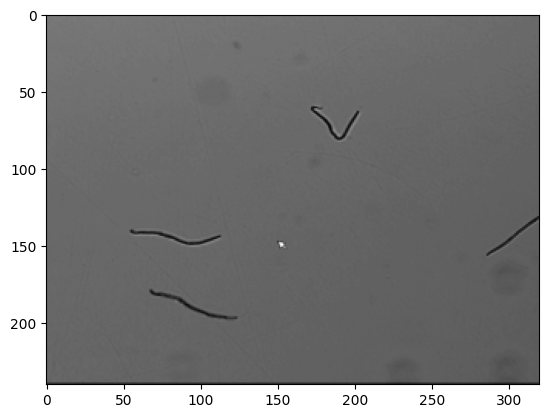

In [6]:
data = np.load("./data/worm.npy")
data = (data - np.min(data)) / np.ptp(data)
data = data[300:450:10]
data = np.array([cv2.resize(frame, (320, 240)) for frame in data])  # Resize

print(data.shape)
plt.imshow(data[0], cmap="gray")
plt.show()

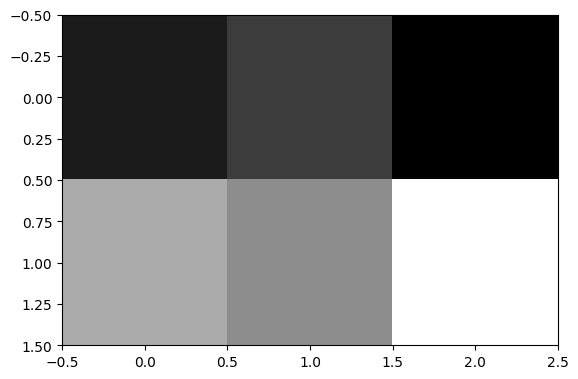

In [44]:
crop = data[0, 80:82, 189:192]
plt.imshow(crop, cmap="gray")

In [45]:
training_data = dt.Value(crop)
model = models.LodeSTAR(input_shape=(None, None, 1))
model.fit(training_data, epochs=30, batch_size=10)

Generating 205 / 200 samples before starting training
Epoch 1/30


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: deeptrack attempted to use a functionality that requires module deeptrack.deeplay, but it couldn't be loaded. Please install deeptrack and retry.
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: deeptrack attempted to use a functionality that requires module deeptrack.deeplay, but it couldn't be loaded. Please install deeptrack and retry.
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
205/205 [==============================] - 7s 11ms/step - total_loss: 1.5621 - consistency_loss: 0.0226
Epoch 2/30
205/205 [==============================] - 14s 66ms/step - total_loss: 1.5248 - consistency_loss: 0.0057                                      
Epoch 3/30
205/205 [==============================] - 14s 68ms/step - total_loss: 1.5173 - consistency_loss: 0.0012                                      
Epoch 4/30
205/205 [==============================] - 14s 69ms/step - total_loss: 1.5328 - consistency_loss: 2.6500e-04                                     
Epoch 5/30
205/205 [====

In [35]:
import itertools

markers = [
    "o", ".", ",", "v", "^", "<", ">", "1", "2", "3", "4", "8", "s", "p", "P", 
    "*", "h", "H", "+", "x", "X", "D", "d", "|", "_", "$A$", "$B$", "$C$", "$D$", "$E$"
]

# # Create a cyclic iterator for markers
# marker_cycle = itertools.cycle(markers)
all_detections = model.predict_and_detect(data)

1/1 [==============================] - 0s 40ms/step


In [37]:
from scipy.optimize import linear_sum_assignment

# Calculate distances between particles in each frame using the Hungarian algorithm
all_frame_coordinates = []

# Initialize with the first frame's detections
current_frame_coords = all_detections[0]
all_frame_coordinates.append(current_frame_coords)

# Iterate over frames
for i in range(1, len(all_detections)):  # Start from the second frame
    next_frame_coords = all_detections[i]

    # Create the cost matrix (Euclidean distances between particles)
    cost_matrix = np.zeros((len(current_frame_coords), len(next_frame_coords)))

    for j, current_coord in enumerate(current_frame_coords):
        for k, next_coord in enumerate(next_frame_coords):
            distance = np.sqrt((current_coord[0] - next_coord[0])**2 + 
                               (current_coord[1] - next_coord[1])**2)
            cost_matrix[j, k] = distance

    # Solve the assignment problem
    row_ind, col_ind = linear_sum_assignment(cost_matrix)

    # Map the coordinates based on the optimal assignments
    matched_coords = [next_frame_coords[k] for j, k in zip(row_ind, col_ind)]

    # Update current_frame_coords for the next iteration
    all_frame_coordinates.append(matched_coords)
    current_frame_coords = matched_coords




314.00156 20.8093


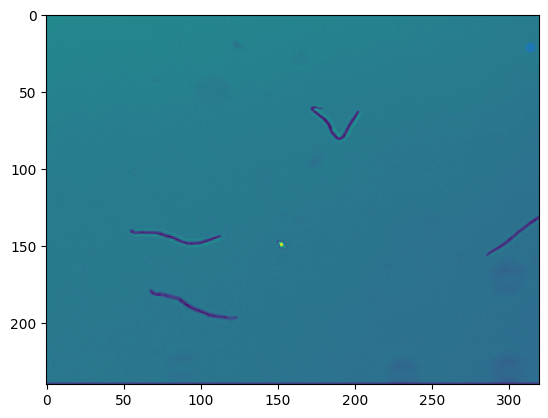

313.94925 10.803834


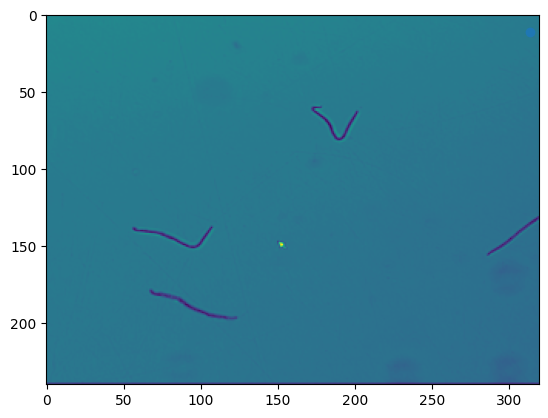

314.00122 20.808012


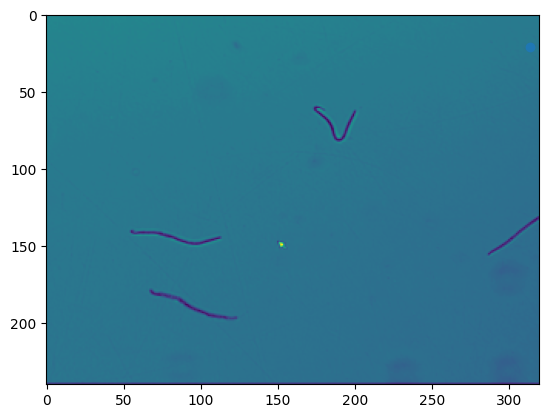

313.95645 20.80628


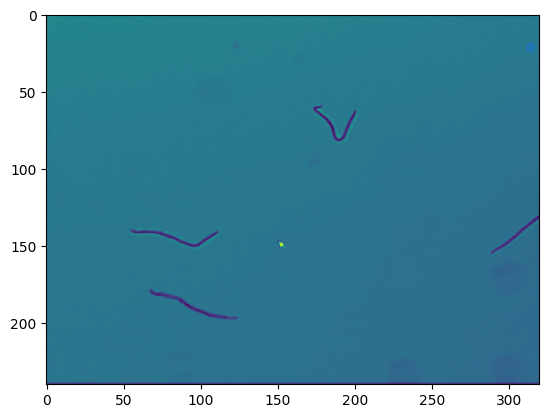

313.95203 20.807354


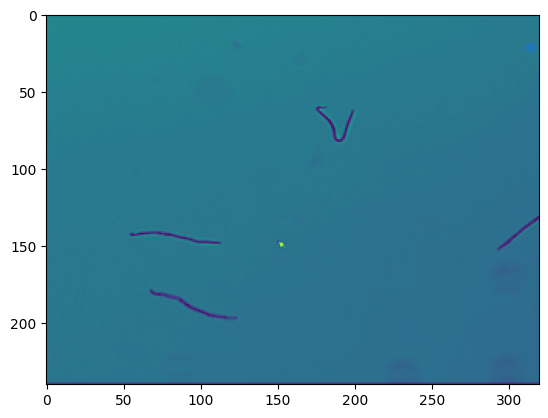

313.97888 20.808643


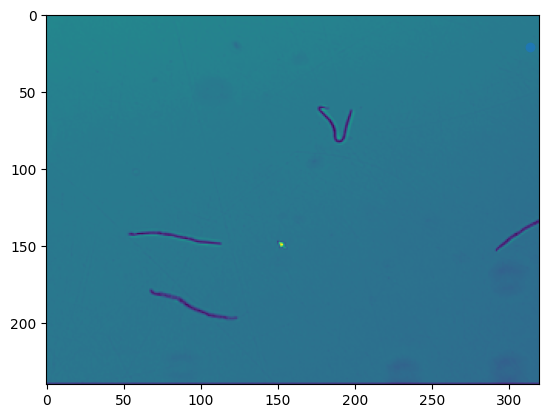

314.00418 14.807143


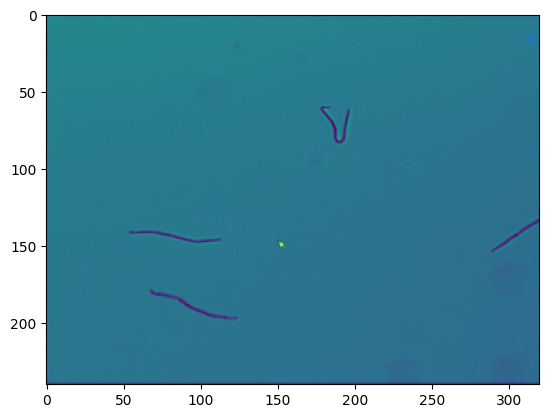

313.99445 20.808527


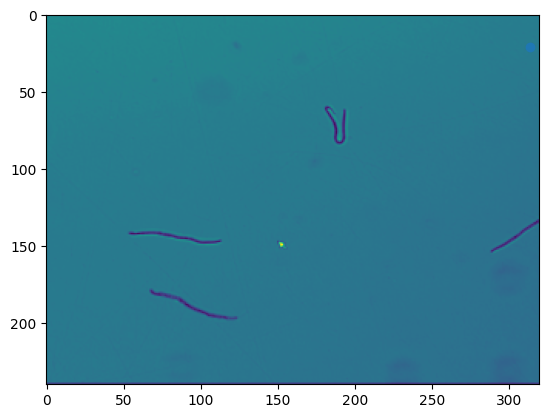

314.01974 20.810448


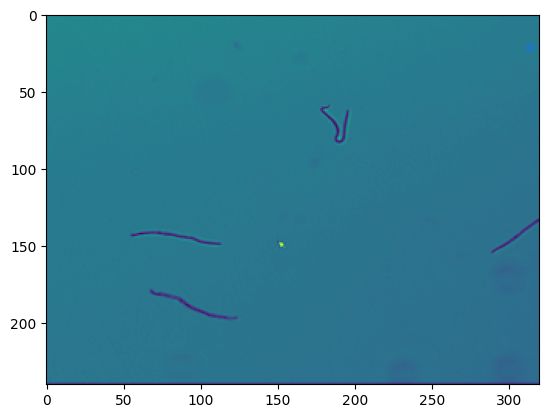

313.96533 20.809822


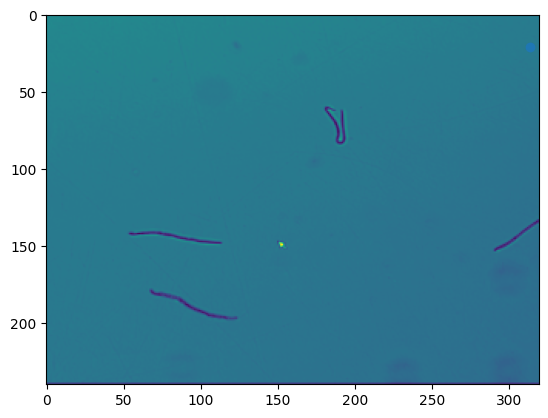

313.97717 20.810345


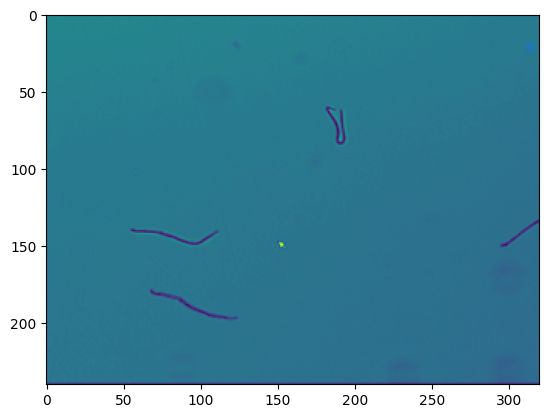

313.98907 20.810062


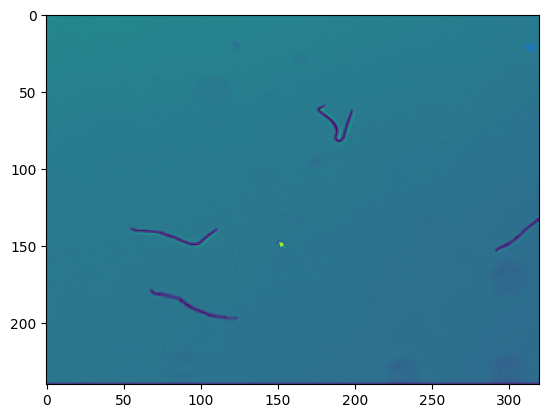

313.98282 20.810137


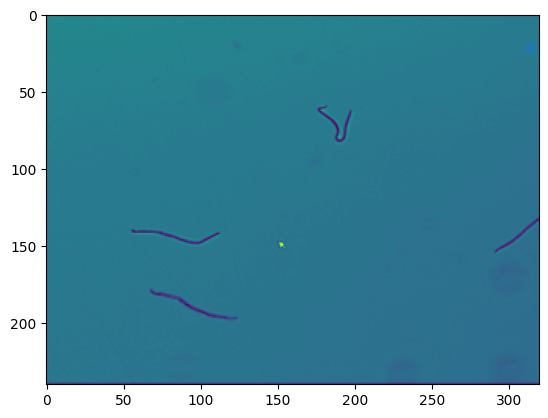

314.03424 8.807977


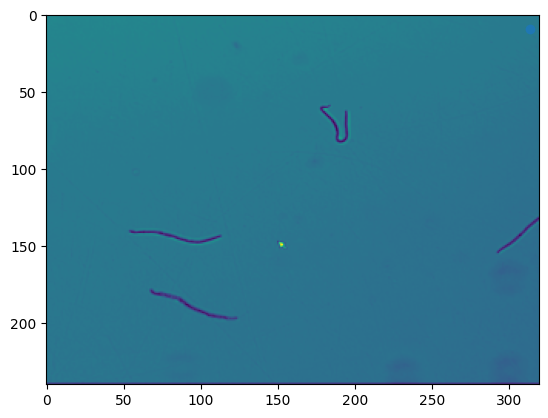

313.98526 8.806087


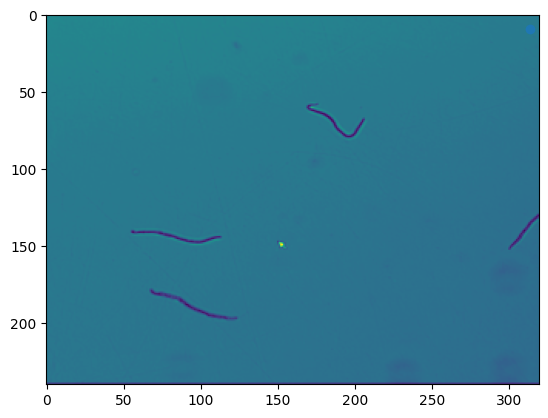

In [38]:
for frame, frame_detections in zip(data, all_frame_coordinates):
    plt.imshow(frame)
    marker_cycle = itertools.cycle(markers) # Create a cyclic iterator for markers

    for detection in frame_detections:
        marker = next(marker_cycle)
        plt.scatter(detection[1], detection[0], marker=marker)
        print(detection[1], detection[0])
        break
    plt.show()

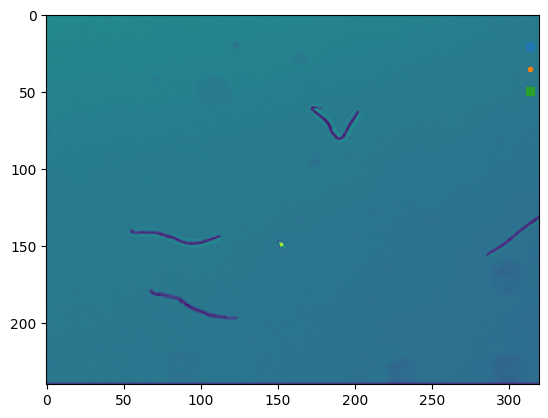

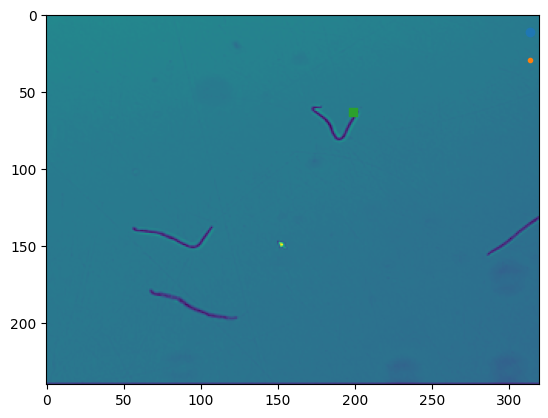

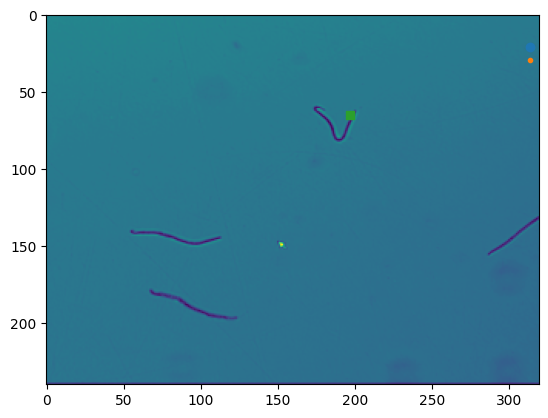

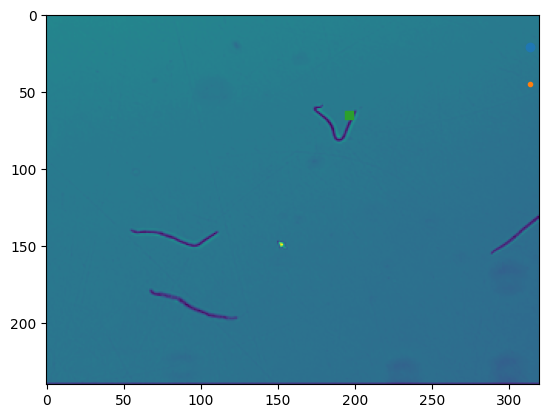

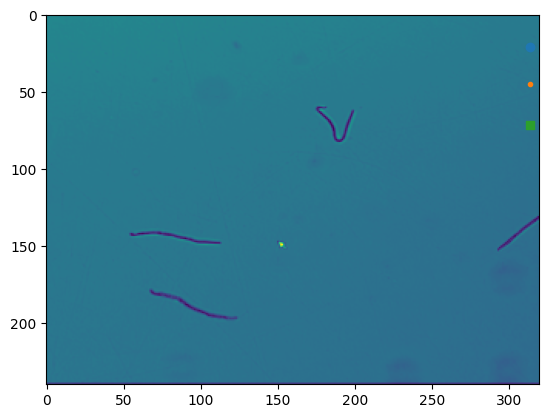

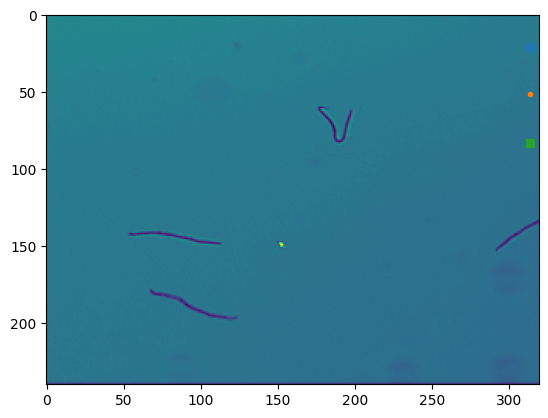

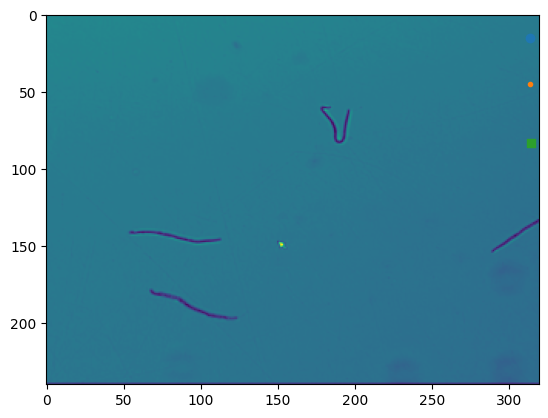

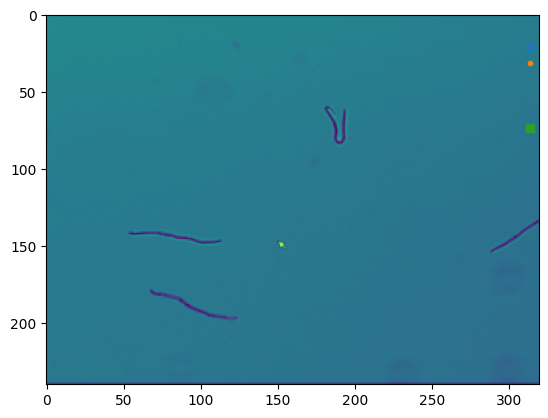

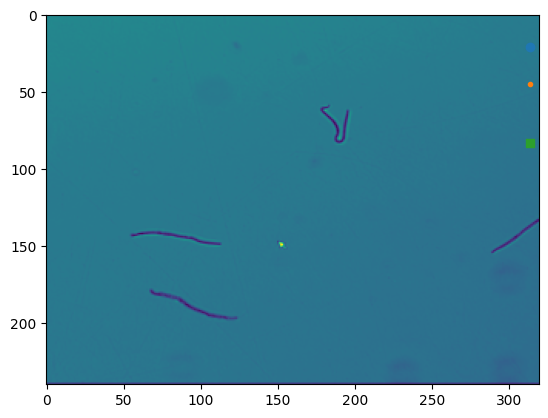

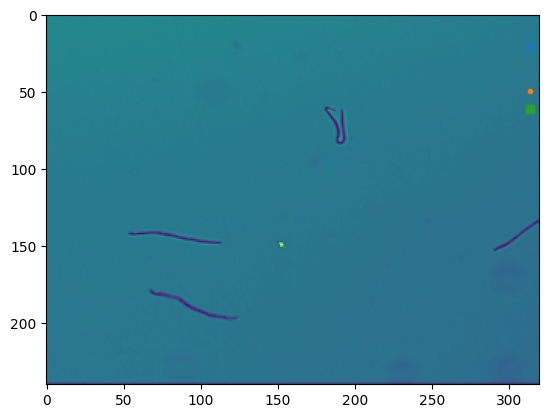

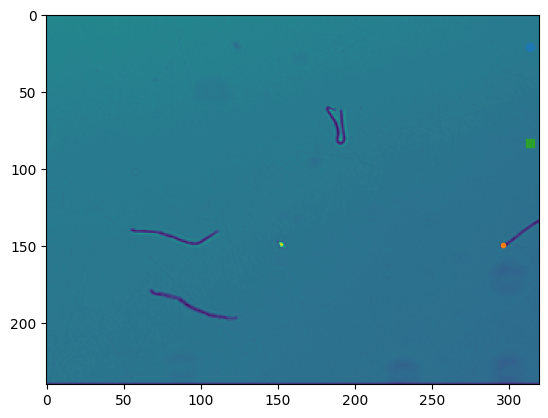

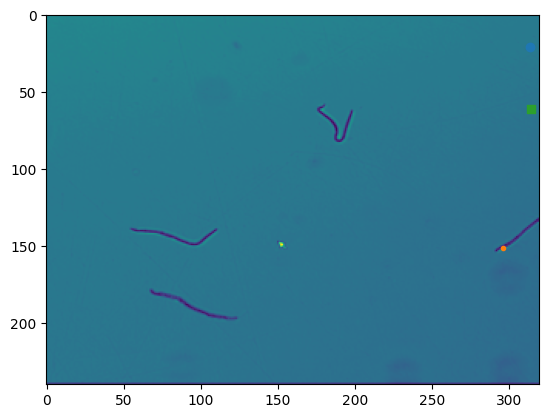

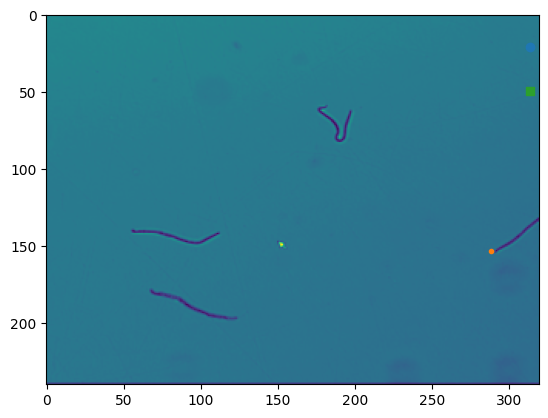

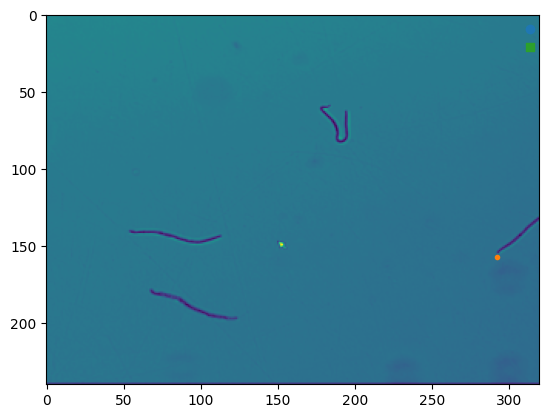

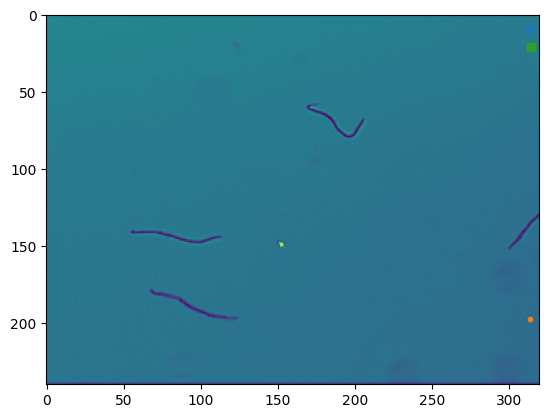

In [39]:
for frame, frame_detections in zip(data, all_frame_coordinates):
    plt.imshow(frame)
    marker_cycle = itertools.cycle(markers) # Create a cyclic iterator for markers

    for i, detection in enumerate(frame_detections):
        marker = next(marker_cycle)
        plt.scatter(detection[1], detection[0], marker=marker)
        if i == 2:
            break
    plt.show()

In [40]:
import os

# Directory to save frames
output_dir = "./frames/"
os.makedirs(output_dir, exist_ok=True)

markers = [
    "o", ".", ",", "v", "^", "<", ">", "1", "2", "3", "4", "8", "s", "p", "P",
    "*", "h", "H", "+", "x", "X", "D", "d", "|", "_", "$A$", "$B$", "$C$", "$D$", "$E$"
]

# Generate frames with markers and save as images
for frame_idx, (frame, frame_detections) in enumerate(zip(data, all_frame_coordinates)):
    fig, ax = plt.subplots()
    ax.imshow(frame, cmap="gray")
    marker_cycle = itertools.cycle(markers)  # Cyclic iterator for markers
    
    for i, detection in enumerate(frame_detections):
        marker = next(marker_cycle)
        ax.scatter(detection[1], detection[0], marker=marker, s=50)
        if i == 2:  # Limit to 3 markers per frame as per your code
            break
    
    # Save the current figure as an image
    output_frame_path = f"{output_dir}frame_{frame_idx:04d}.png"
    plt.axis("off")
    plt.savefig(output_frame_path, bbox_inches="tight", pad_inches=0)
    plt.close(fig)

print(f"Frames saved to {output_dir}")

Frames saved to ./frames/


Remember to use this command to generate the video: ffmpeg -r 5 -f image2 -i ./frames/frame_%04d.png -vf "scale=trunc(iw/2)*2:trunc(ih/2)*2" -vcodec libx264 -crf 25 -pix_fmt yuv420p output_video.mp4